In [1]:
import sys
[sys.path.append(i) for i in ['.', '..']]
import torch
import numpy as np
from mirtorch.alg.cg import CG
from mirtorch.linear import LinearMap, FFTCn, NuSense, Sense, FFTCn, Identity, Diff3dgram, Gmri
import matplotlib.pyplot as plt
import copy
import h5py
import torchkbnufft as tkbn
import time
import os
from einops import rearrange, reduce

%load_ext autoreload
%autoreload 2

## Non-Cartesian reconstruction for 3D MRI
Here we tested a 3d non-Cartesian reconstruction task. Special thanks to Dinank Gupta from UofM for generously providing the data. 

### Load the data

In [2]:
# Download the files
if not os.path.exists('./3d.h5'):
    import wget
    url = "https://www.dropbox.com/s/o0l98u323zkgkpx/3d.h5?dl=1"
    wget.download(url, './3d.h5')
hf = h5py.File('./3d.h5', 'r')
nx = 128
ny = 128
nz = 15
device0 = torch.device('cuda:0')
# Load Non-cartesian k-space trajectory, [nbatch (1), ndimension, nshot, nreadout]
ktraj = torch.tensor(hf['ktraj'][()]).unsqueeze(0).to(device = device0, dtype = torch.float)
print('traj shape', ktraj.shape)
# Load k-space, [nbatch (1), ncoil, nshot, nreadout]
k = rearrange(torch.tensor(hf['k_r'][()] + 1j*hf['k_i'][()]), 'c s r -> 1 r c s').to(device = device0, dtype = torch.cfloat)
print('k shape', k.shape)
# Load sensetivity maps
smap = rearrange(torch.tensor(hf['s_r'][()] + 1j*hf['s_i'][()]), 'b c h w -> 1 b w h c').to(device = device0, dtype = torch.cfloat)
print('smap shape', smap.shape)
# Load fmaps
fmap = rearrange(torch.tensor(hf['b0'][()]), 'b c h -> 1 h c b').to(device = device0, dtype = torch.float)
# fmap = np.transpose(fmap, (0,2,1))
print('fmap shape', fmap.shape)

traj shape torch.Size([1, 3, 60, 4120])
k shape torch.Size([1, 8, 60, 4120])
smap shape torch.Size([1, 8, 128, 128, 15])
fmap shape torch.Size([1, 128, 128, 15])


In [3]:
# Define NuSENSE operator
# b0 = torch.tensor(fmap[iz,:,:]).to(device0).unsqueeze(0)
A = NuSense(smap, rearrange(ktraj, 'b c h w -> b c (h w)'))
Iadj = A.H*rearrange(k, 'b c h w -> b c (h w)')
T = Diff3dgram(A.size_in)
CG_NoB0 = CG(A.H*A+0.0001*T, max_iter = 20)
I_NoB0 = CG_NoB0.run(Iadj, Iadj)

/data/guanhuaw/anaconda3/envs/mirtorch/lib/python3.9/site-packages/torchkbnufft-1.3.1b20211109-py3.9.egg/torchkbnufft/_nufft/interp.py:651: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  if num_threads // factor <= data.shape[0] * data.shape[1]:


In [4]:
# Define field-corrected Gmri operator
# b0 = torch.tensor(fmap[iz,:,:]).to(device0).unsqueeze(0)
Gop = Gmri(smaps=smap, zmap = -fmap, traj = ktraj)
Ib0 = Gop.H*k
T = Diff3dgram(Gop.size_in)
CG_FD_b0 = CG(Gop.H*Gop+0.0001*T, max_iter = 20)
I_FD_b0 = CG_FD_b0.run(Ib0, Ib0)

Text(0.5, 1.0, 'CG-SENSE without B0)')

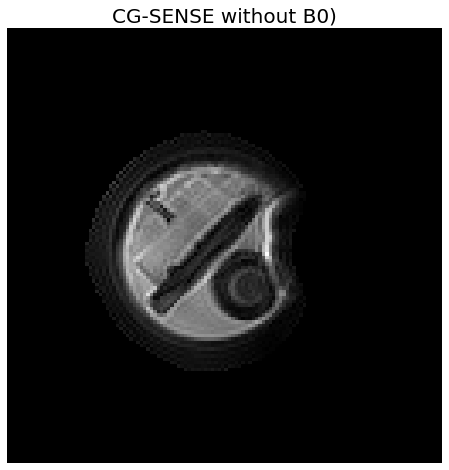

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(torch.abs(I_NoB0[0,0,:,:,10]).cpu().data.numpy(),cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('CG-SENSE without B0)', size = 20)

Text(0.5, 1.0, 'CG-SENSE with B0)')

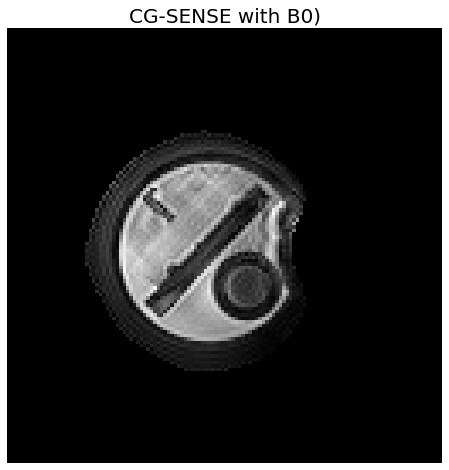

In [11]:
plt.figure(figsize=(8,8))
plt.imshow(torch.abs(I_FD_b0[0,0,:,:,10]).cpu().data.numpy(),cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('CG-SENSE with B0)', size = 20)